# Distributed Model Saving & Loading

This notebook demonstrates four features of cuML distributed models
1. Extracting a combined single-GPU model from a trained distributed model to perform single-GPU inference
1. Saving & loading of combined model
3. Using a single-GPU model to perform distributed inference

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

First, we create a single node multi-GPU Dask cluster that creates a number of workers equal to those available in the `CUDA_VISIBLE_DEVICES` environment variable and maps each Dask worker to a single GPU. 

To start a multi-node multi-GPU cluster, start a Dask scheduler and one `dask-cuda-worker` per physical machine. Refer to the [Dask-CUDA](https://github.com/rapidsai/dask-cuda) project more information on `LocalCUDACluster` and `dask-cuda-worker`. 

In [2]:
from dask.distributed import Client
from dask_cuda import LocalCUDACluster

cluster = LocalCUDACluster()
client = Client(cluster)
client

bokeh.server.util - WARNING - Host wildcard '*' will allow connections originating from multiple (or possibly all) hostnames or IPs. Use non-wildcard values to restrict access explicitly


Client Scheduler: tcp://127.0.0.1:42034 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 50.39 GB


We will use `make_blobs` from the `cuml.dask.datasets` package to create create a distributed dataset of clustered points for this example. 

In [3]:
from cuml.dask.datasets import make_blobs

n_workers = len(client.scheduler_info()["workers"].keys())

X, y = make_blobs(n_samples=100000, 
                  n_features=2, 
                  centers=5, 
                  cluster_std=0.4, 
                  random_state=0,
                  n_parts=n_workers*5)

X = X.persist()
y = y.persist()

ModuleNotFoundError: No module named 'cuml'

We verify the distribution of the data across the Dask workers

In [4]:
client.has_what()

{'tcp://127.0.0.1:37639': (), 'tcp://127.0.0.1:41766': ()}

### Train Distributed Model

In [5]:
from cuml.dask.cluster import KMeans

dist_model = KMeans(n_clusters=5)

The combined model returns `None` when not yet trained

In [6]:
print(dist_model.get_combined_model())

None


In [7]:
dist_model.fit(X)

When an attribute doesn't exist on the distributed model, it is proxied to the underlying single-GPU models.

Note: If needed, we could move the proxy logic into a function that can be overrided in subclasses for special cases (e.g., random forests). 

In [8]:
dist_model.cluster_centers_

array([[ 8.498238  , -1.0741726 ],
       [-9.220038  ,  9.375686  ],
       [ 4.803193  ,  8.420499  ],
       [-0.59614277,  0.26271135],
       [ 3.3411913 , -7.80035   ]], dtype=float32)

If an attribute doesn't exist, we get an error

In [9]:
try:
    dist_model.cluster_centers_fail_
except AttributeError:
    print("Failed")

Failed


The MG subclass also provides the ability to treat attributes differently when they don't make sense in the distributed context. 

For example, calling `combined_model.labels_` would only reference the labels for one partition. Collecting the labels assigned to the training inputs onto a single GPU will not scale, so this attribute gets blanked out in the MG version

In [10]:
print(dist_model.labels_)

None


If needed, the labels can be computed again

In [11]:
y_hat = dist_model.predict(X).compute().get()

### Visualize Clusters

Plot ground truth clusters

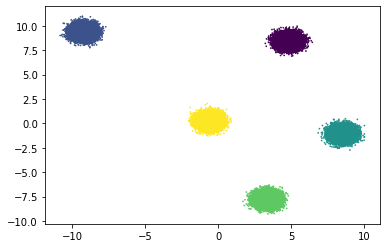

In [12]:
import matplotlib.pyplot as plt

X_host = X.compute().get()
y_host = y.compute().get()

plt.scatter(X_host[:,0], X_host[:,1], c=y_host, s=0.5)

Plot predicted clusters

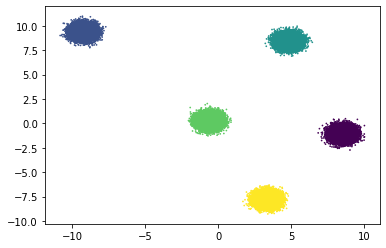

In [13]:
plt.scatter(X_host[:,0], X_host[:,1], c=y_hat, s=0.5)

### Extract combined single-GPU model

In [14]:
single_gpu_model = dist_model.get_combined_model()
type(single_gpu_model)

cuml.cluster.kmeans_mg.KMeansMG

In [15]:
single_gpu_model.cluster_centers_

array([[ 8.498238  , -1.0741726 ],
       [-9.220038  ,  9.375686  ],
       [ 4.803193  ,  8.420499  ],
       [-0.59614277,  0.26271135],
       [ 3.3411913 , -7.80035   ]], dtype=float32)

### Save & load model

Serialize model to disk 

In [16]:
import pickle
pickle.dump(single_gpu_model, open("kmeans_model.pkl", "wb"))

Load serialized model

In [17]:
single_gpu_model = pickle.load(open("kmeans_model.pkl", "rb"))
type(single_gpu_model)

cuml.cluster.kmeans_mg.KMeansMG

### Perform Single GPU Inference & Visualize

In [18]:
y_hat = single_gpu_model.predict(X.compute()).get()

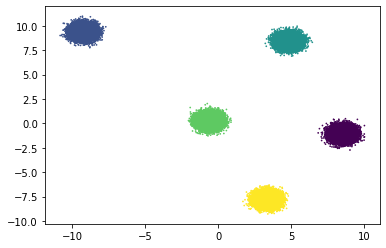

In [19]:
plt.scatter(X_host[:,0], X_host[:,1], c=y_hat, s=0.5)

### Perform Distributed Inference & Visualize

In [20]:
from dask_ml.wrappers import ParallelPostFit

dist_model = ParallelPostFit(estimator=single_gpu_model)

We predict our clusters on the distributed dataset and notice `ParallelPostFit` returns a CuPy array

In [21]:
y_hat = dist_model.predict(X).compute()
type(y_hat)

cupy.core.core.ndarray

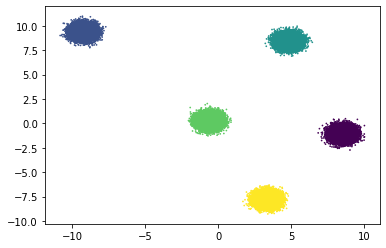

In [22]:
plt.scatter(X_host[:,0], X_host[:,1], c=y_hat.get(), s=0.5)